- 预测2016.11.01-2016.11.14客户流量.结果为非负整数。
- 提供2015.07.01到2016.10.31（除去2015.12.12）的商家数据，用户支付行为数据以及用户浏览行为数据。
- 提供数据的类型统一为string类型，提交预测的类型为整形。文件统一为utf-8编码，没有标题行，并以“,”分隔的csv格式。

### 供参考的特征生成方法

- centrality measures (mostly median) on sales of the same store/weekday/promo during last 3, 6, 12 and 24 months (some spread measures too but they were more prone to overfitting)
- linear model (ridge) predictions for each store on weekday/promo/dayssince2000 on last 3 and 12 months to help the tree model extrapolate
- number of schoolholidays this week, last week and next week
- aggregates by store (avg sales per customer, promo sales ratio, saturday sales ratio, holiday sales ratio)
- daycounters (before, during and after) for things like position within promo cycle, promo2 cycle, summerholidays and refurbishments

External data that were posted to the forum by others (big thanks!):

- maxtemp and precipmm from the weather files by state
- summerholiday start dates


In [97]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
data_col=['user_id','shop_id','time_stamp']

In [3]:
shop_info_col=['shop_id','city_name','location_id','per_pay','score','comment_cnt','shop_level','cate_1_name','cate_2_name','cate_3_name']

In [4]:
shop_info=pd.read_csv('../dataset/shop_info.txt',header=None)
shop_info.columns=shop_info_col

shop_info.head()

,shop_id,city_name,location_id,per_pay,score,comment_cnt,shop_level,cate_1_name,cate_2_name,cate_3_name
0,1,湖州,885,8,4.0,12.0,2,美食,休闲茶饮,饮品/甜点
1,2,哈尔滨,64,19,NaN,NaN,1,超市便利店,超市,NaN
2,3,南昌,774,5,3.0,2.0,0,美食,休闲茶饮,奶茶
3,4,天津,380,18,NaN,NaN,1,超市便利店,超市,NaN
4,5,杭州,263,2,2.0,2.0,0,美食,休闲食品,生鲜水果


In [5]:
#data_view=pd.read_csv('../dataset/user_view.txt',header=None)

#data_view.columns=data_col

In [48]:
data_pay=pd.read_csv('../dataset/user_pay.txt',header=None)
data_pay.columns=data_col

data_pay.head(15)

,user_id,shop_id,time_stamp
0,22127870,1862,2015-12-25 17:00:00
1,3434231,1862,2016-10-05 11:00:00
2,16955285,1862,2016-02-10 15:00:00
3,13799128,1862,2016-01-13 14:00:00
4,13799128,1862,2016-07-05 12:00:00
5,20244878,1862,2016-09-17 15:00:00
6,20244878,1862,2016-05-29 16:00:00
7,438444,1862,2016-02-22 17:00:00
8,22003193,1862,2016-08-07 15:00:00
9,20244878,1862,2016-04-17 16:00:00


In [49]:
data_pay.time_stamp=pd.to_datetime(data_pay.time_stamp, format='%Y/%m/%d %H:%M:%S')

In [50]:
data_pay['data']=data_pay.time_stamp.dt.date
#data_pay['day']=data_pay.time_stamp.dt.day
#data_pay['dayofweek']=data_pay.time_stamp.dt.dayofweek
#data_pay['month']=data_pay.time_stamp.dt.month

In [51]:
data_pay.head()

,user_id,shop_id,time_stamp,data
0,22127870,1862,2015-12-25 17:00:00,2015-12-25
1,3434231,1862,2016-10-05 11:00:00,2016-10-05
2,16955285,1862,2016-02-10 15:00:00,2016-02-10
3,13799128,1862,2016-01-13 14:00:00,2016-01-13
4,13799128,1862,2016-07-05 12:00:00,2016-07-05


In [52]:
feature_daypay=pd.DataFrame(data_pay.groupby(['shop_id','data'])['user_id'].count())
feature_daypay.rename(columns={'user_id':'daypay'},inplace=True)
feature_daypay.to_csv('../tempfile/feature_daypay.csv')
feature_daypay=pd.read_csv('../tempfile/feature_daypay.csv')

In [53]:
feature_daypay.head()

,shop_id,data,daypay
0,1,2015-10-10,188
1,1,2015-10-11,272
2,1,2015-10-12,257
3,1,2015-10-13,239
4,1,2015-10-14,277


In [44]:
# 14天的预测值 
# 分割数据集

#  2016-10-18  2016-10-31
#  2016-10-3  2016-10-17

# 过去一周平均业绩
#  过去一个月平均业绩
# 过去3个月平均业绩
# 过去半年平均业绩
# 过去一年平均业绩
# 去年同期平均业绩

## 多数店记录从2016-06-22 开始

In [54]:
train=feature_daypay[feature_daypay.data<'2016-10-18']

test=feature_daypay[feature_daypay.data>='2016-10-18']

In [55]:
train.shape

(571375, 3)

In [56]:
test.shape

(27900, 3)

In [102]:
## 这部分处理，意在观察记录的开始时间，从而对构造特征的时间起点提供参考意见

In [81]:
record_begin=[]
for number in range(1,2001):
    #print train[train.shop_id==number]['data'].min()
    record_begin.append(train[train.shop_id==number]['data'].min())

In [82]:
record_begin=pd.DataFrame(record_begin,index=range(1,2001),columns=['record_begin'])

record_begin.record_begin=pd.to_datetime(record_begin.record_begin, format='%Y/%m/%d')

record_begin['count']=1

In [94]:
record_count=record_begin.groupby('record_begin')['count'].sum()

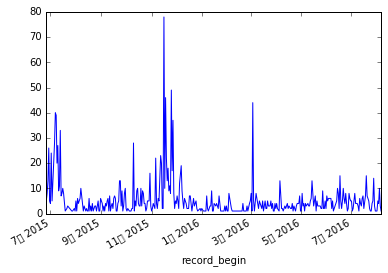

In [98]:
record_count.plot()

In [101]:
record_count

record_begin
2015-06-26     5
2015-06-27     8
2015-06-28    13
2015-06-29    26
2015-06-30     5
2015-07-01     4
2015-07-02    24
2015-07-03     5
2015-07-06    28
2015-07-07    40
2015-07-08    39
2015-07-09    20
2015-07-10    27
2015-07-11     9
2015-07-12    11
2015-07-13    33
2015-07-14     7
2015-07-15     8
2015-07-16    10
2015-07-17     8
2015-07-19     1
2015-07-21     2
2015-07-22     3
2015-07-27     1
2015-07-28     1
2015-07-30     2
2015-07-31     1
2015-08-01     5
2015-08-02     1
2015-08-03     6
              ..
2016-07-07     4
2016-07-08     4
2016-07-09     3
2016-07-10     1
2016-07-11     6
2016-07-12     4
2016-07-13     3
2016-07-14     6
2016-07-15     7
2016-07-16     2
2016-07-18     7
2016-07-19    15
2016-07-20     7
2016-07-21     6
2016-07-22     5
2016-07-23     2
2016-07-24     1
2016-07-25     1
2016-07-26     4
2016-07-27     5
2016-07-28    14
2016-07-29     3
2016-07-30     1
2016-07-31     1
2016-08-01     1
2016-08-02     5
2016-08-03     4
2

In [103]:
## 通过观察可知，8月6号开始，能保证每家店铺都有记录。
### 我们的第一组特征，从此开始

In [118]:
train.head()

,shop_id,data,daypay
0,1,2015-10-10,188
1,1,2015-10-11,272
2,1,2015-10-12,257
3,1,2015-10-13,239
4,1,2015-10-14,277


In [107]:
train2=train[train.data>='2016-08-18']

In [110]:
# 14天的预测值 
# 分割数据集

#  2016-08-18 2016-10-18 2个月


# 过去一周平均业绩
# 过去两周平均业绩
# 过去一个月平均业绩
# 过去2个月平均业绩

## 多数店记录从2016-06-22 开始

In [143]:
last1_week=train2[(train2.data<'2016-10-18')&(train2.data>='2016-10-11')]
print last1_week['shop_id'].drop_duplicates().count()
last1_week_feature=last1_week.groupby('shop_id')['daypay'].agg({'sum':np.sum,'mean':np.mean,'max':np.max,'min':np.min,'var':np.var,'median':np.median})
last1_week_feature.to_csv('../tempfile/last1_week_feature.csv')
last1_week_feature=pd.read_csv('../tempfile/last1_week_feature.csv')
last1_week_feature.head()

1992


,shop_id,min,max,sum,median,var,mean
0,1,207,264,1700,244.0,423.476190,242.857143
1,3,56,119,549,71.0,484.619048,78.428571
2,4,71,200,845,113.0,2164.904762,120.714286
3,5,185,274,1536,218.0,826.285714,219.428571
4,6,83,137,717,91.0,445.285714,102.428571


In [144]:
last2_week=train2[(train2.data<'2016-10-18')&(train2.data>='2016-10-04')]
print last2_week['shop_id'].drop_duplicates().count()
last2_week_feature=last2_week.groupby('shop_id')['daypay'].agg({'sum':np.sum,'mean':np.mean,'max':np.max,'min':np.min,'var':np.var,'median':np.median})
last2_week_feature.to_csv('../tempfile/last2_week_feature.csv')
last2_week_feature=pd.read_csv('../tempfile/last2_week_feature.csv')
last2_week_feature.head()

1996


,shop_id,min,max,sum,median,var,mean
0,1,207,277,3468,250.5,322.219780,247.714286
1,2,34,125,483,108.0,1363.300000,96.600000
2,3,56,121,1158,76.0,394.219780,82.714286
3,4,71,200,1610,112.5,1271.538462,115.000000
4,5,2,312,2678,214.5,9788.681319,191.285714


In [145]:
last1_month=train2[(train2.data<'2016-10-18')&(train2.data>='2016-09-18')]
print last1_month['shop_id'].drop_duplicates().count()
last1_month_feature=last1_month.groupby('shop_id')['daypay'].agg({'sum':np.sum,'mean':np.mean,'max':np.max,'min':np.min,'var':np.var,'median':np.median})
last1_month_feature.to_csv('../tempfile/last1_month_feature.csv')
last1_month_feature=pd.read_csv('../tempfile/last1_month_feature.csv')
last1_month_feature.head()

1997


,shop_id,min,max,sum,median,var,mean
0,1,164,309,7195,239.5,1083.316092,239.833333
1,2,34,161,1904,82.0,766.333333,90.666667
2,3,55,152,2549,78.0,656.309195,84.966667
3,4,71,203,3502,106.5,1315.581609,116.733333
4,5,1,312,5385,203.0,10352.810345,179.500000
